In [14]:
import os
import joblib

import numpy as np

import matplotlib.pyplot as plt

models_dir = "models_overlap"
print(f"Models reside in: {models_dir}")

Models reside in: ./models


In [27]:
# sampling function. let it dream from a random starting state
def sample_rbm(rbm, n_fantasy=10_000, n_gibbs=300):
    v = np.random.rand(n_fantasy, rbm.n_features_in_) > 0.5
    for _ in range(n_gibbs):
        v = rbm.gibbs(v)
    return v.astype(int)


# helper function to compute the unnormalized probability to obtain a state from the free energy of the RBM
def unnormalized_prob(rbm, v):
    return np.exp(-rbm._free_energy(v))


def w_overlap(rbm, N):
    # term 1: first MC sample, only keep one-hots, evaluate formula
    samples = sample_rbm(rbm)
    M = len(samples)
    mask = (samples.sum(1) == 1)
    onehot_samples = samples[mask]

    if len(onehot_samples) == 0:  # in case no one-hot was sampled
        return 0.0

    p_sample = unnormalized_prob(rbm, onehot_samples)
    term1 = np.sum(1 / np.sqrt(p_sample)) / M

    # Term 2: evaluate the formula but only for the one-hot states
    onehot_states = np.eye(N, dtype=int)
    p_state = unnormalized_prob(rbm, onehot_states)
    term2 = np.sqrt(p_state).sum() / N

    # take the square root to get the overlap
    O = np.sqrt(term1 * term2)
    return O

In [28]:
# evaluating for each stored model

Ns_list = [50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000]
chain_lengths = [20, 40, 80]

results = {N: {} for N in chain_lengths}
for N in chain_lengths:
    for Ns in Ns_list:
        path = os.path.join(models_dir, f"rbm_w_vanilla_{N}_{Ns}.pkl")
        if not os.path.isfile(path):
            print(f"[skip] {path} (not found)")
            continue

        rbm = joblib.load(path)
        results[N][Ns] = w_overlap(rbm, N)

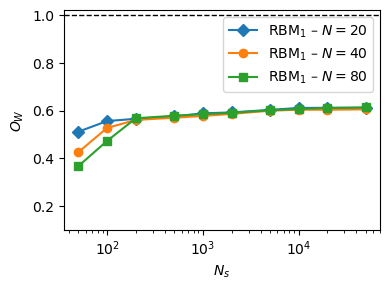

In [31]:
plt.figure(figsize=(4, 3))
markers = {20: "D", 40: "o", 80: "s"}
for N, marker in markers.items():
    if not results[N]:
        continue
    Ns_vals, OW_vals = zip(*sorted(results[N].items()))
    plt.plot(Ns_vals, OW_vals, marker=marker, label=fr"RBM$_1$ – $N={N}$")

plt.xscale("log")
plt.ylim(0.1, 1.02)
plt.ylabel(r"$O_W$")
plt.xlabel(r"$N_s$")
plt.axhline(1.0, ls="--", lw=1, color="k")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

In [45]:
# load the model models/rbm_w_vanilla_20_20000.pkl

rbm = joblib.load("models_overlap/rbm_w_vanilla_80_50000.pkl")

# test the one-hot sampling
samples = sample_rbm(rbm, n_fantasy=10_000, n_gibbs=300)
M = samples.shape[0]
mask = (samples.sum(axis=1) == 1)
m_one = mask.sum()
m_non = M - m_one

print(f"Total samples:         {M}")
print(f"One-hot samples:       {m_one} ({m_one/M:.2%})")
print(f"Non–one-hot samples:   {m_non} ({m_non/M:.2%})")

Total samples:         10000
One-hot samples:       3760 (37.60%)
Non–one-hot samples:   6240 (62.40%)


In [46]:
# the resulting product of the terms will yield sth like 0.364, taking the square root we get to about 0.6 overlap
np.sqrt(m_one)

61.318838867023565

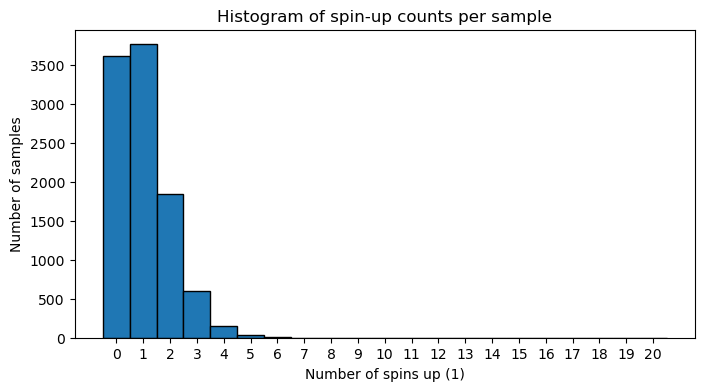

In [47]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()